# 07. Gradients and Autograd - The Engine of Deep Learning ⚡

Welcome to the **most fundamental** concept in deep learning! 🧠

Understanding gradients and automatic differentiation is like understanding the engine of a car - you don't need to know every detail to drive, but knowing how it works makes you a much better driver!

## 🎯 Learning Objectives

Master the core engine that powers all deep learning:

- **What gradients are** and why they're crucial for learning
- **How automatic differentiation works** step by step
- **PyTorch's computational graph** and how to work with it
- **Advanced gradient techniques** used in production
- **Common gradient problems** and how to solve them
- **Custom gradient functions** for advanced use cases

## 🧩 What You'll Build

- **Interactive gradient visualizer** - See gradients in action!
- **Computational graph explorer** - Understand how PyTorch tracks operations
- **Gradient debugging toolkit** - Diagnose and fix gradient problems
- **Custom autograd functions** - Extend PyTorch's capabilities
- **Performance optimization** - Make gradient computation faster

## 🌟 Why This Matters

Gradients are the **heartbeat** of machine learning:

| Without Understanding Gradients | With Gradient Mastery         |
| ------------------------------- | ----------------------------- |
| 🎲 Trial and error debugging    | 🔍 Systematic problem solving |
| 🐌 Inefficient training         | ⚡ Optimized performance      |
| 🚫 Limited to basic models      | 🚀 Advanced architectures     |
| 🤷‍♂️ "Black box" thinking         | 🧠 Deep understanding         |

Let's unlock the secrets of automatic differentiation! 🔓


## 🧮 What Are Gradients and Why Do We Need Them?

Before diving into automatic differentiation, let's understand what gradients actually are and why they're the foundation of all machine learning!

### 🎯 Gradients: The GPS of Machine Learning

Think of gradients as **directions on a map**:

- 🗺️ **The map**: The loss landscape (how wrong our model is)
- 📍 **Current location**: Current model parameters
- 🧭 **Gradient**: Which direction to move to reduce error
- 🚶‍♂️ **Step size**: Learning rate (how big steps to take)

### 📊 Mathematical Intuition

A gradient tells us:

1. **Direction**: Which way to adjust parameters
2. **Magnitude**: How much the loss changes with small parameter changes

For a function f(x), the gradient df/dx tells us:

- If **positive**: Increasing x increases f(x)
- If **negative**: Increasing x decreases f(x)
- If **zero**: We're at a local minimum/maximum

### 🤖 Why Automatic Differentiation?

Computing gradients manually for complex neural networks would be:

- ⏰ **Extremely time-consuming** (thousands of parameters!)
- 🐛 **Error-prone** (one mistake ruins everything)
- 🔄 **Inflexible** (change model = recompute everything)

**Automatic differentiation** solves this by computing exact gradients automatically! ✨


In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
import warnings

warnings.filterwarnings("ignore")

# Set style for professional plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("🚀 Gradient and AutoGrad Learning Environment Ready!")
print("📚 Let's explore the magic behind automatic differentiation!")

🚀 Gradient and AutoGrad Learning Environment Ready!
📚 Let's explore the magic behind automatic differentiation!


## 🎨 Visualizing Gradients: From Simple to Complex

Let's start with visual intuition before diving into code!


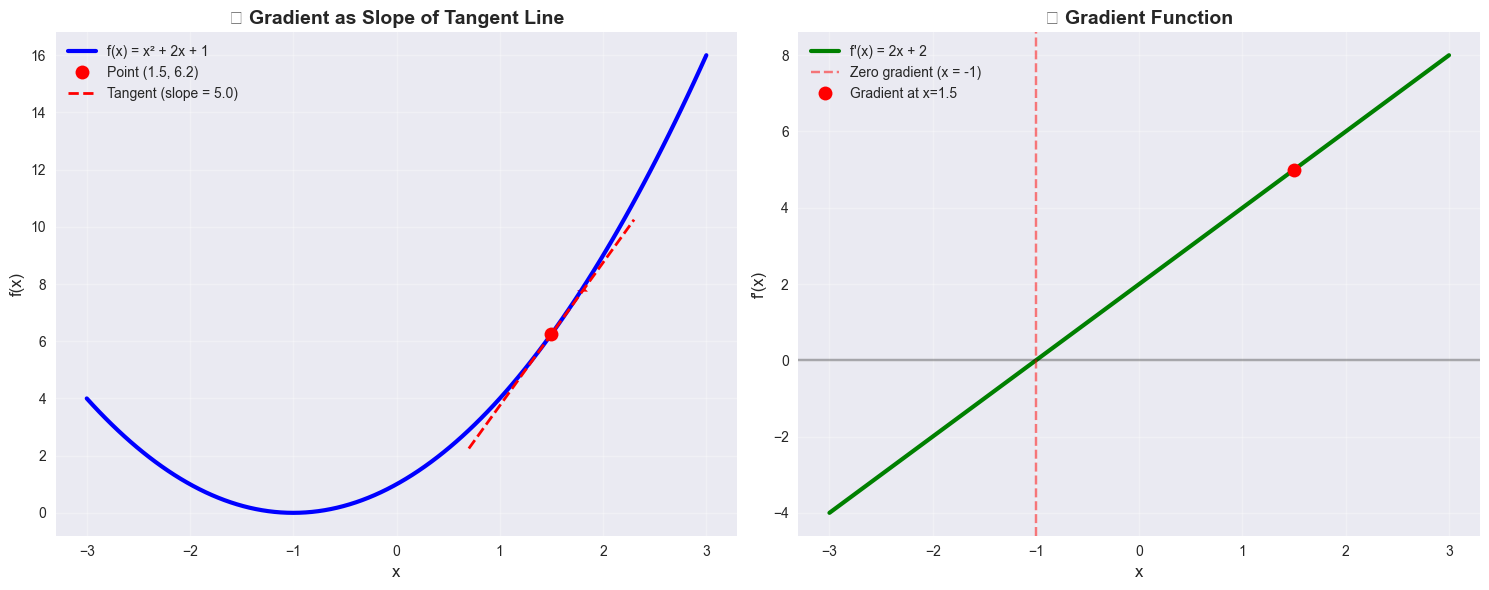

🎯 At x = 1.5:
   📊 Function value: f(1.5) = 6.25
   📐 Gradient: f'(1.5) = 5.00
   🧭 Direction: Increasing


In [20]:
def visualize_1d_gradient():
    """Visualize gradient as slope on a 1D function"""

    # Create a simple quadratic function
    x = np.linspace(-3, 3, 100)
    y = x**2 + 2 * x + 1  # f(x) = x² + 2x + 1

    # Analytical gradient: f'(x) = 2x + 2
    gradient = 2 * x + 2

    # Pick a point to show tangent
    point_x = 1.5
    point_y = point_x**2 + 2 * point_x + 1
    point_grad = 2 * point_x + 2

    # Create tangent line
    tangent_x = np.linspace(point_x - 0.8, point_x + 0.8, 10)
    tangent_y = point_y + point_grad * (tangent_x - point_x)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Function with tangent line
    ax1.plot(x, y, "b-", linewidth=3, label="f(x) = x² + 2x + 1")
    ax1.plot(
        point_x,
        point_y,
        "ro",
        markersize=10,
        label=f"Point ({point_x:.1f}, {point_y:.1f})",
    )
    ax1.plot(
        tangent_x,
        tangent_y,
        "r--",
        linewidth=2,
        label=f"Tangent (slope = {point_grad:.1f})",
    )

    # Add arrow showing gradient direction
    arrow_scale = 0.3
    ax1.arrow(
        point_x,
        point_y,
        arrow_scale,
        point_grad * arrow_scale,
        head_width=0.1,
        head_length=0.1,
        fc="red",
        ec="red",
    )

    ax1.set_xlabel("x", fontsize=12)
    ax1.set_ylabel("f(x)", fontsize=12)
    ax1.set_title(
        "🔍 Gradient as Slope of Tangent Line", fontsize=14, fontweight="bold"
    )
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Gradient function
    ax2.plot(x, gradient, "g-", linewidth=3, label="f'(x) = 2x + 2")
    ax2.axhline(y=0, color="k", linestyle="-", alpha=0.3)
    ax2.axvline(
        x=-1, color="r", linestyle="--", alpha=0.5, label="Zero gradient (x = -1)"
    )
    ax2.plot(
        point_x, point_grad, "ro", markersize=10, label=f"Gradient at x={point_x:.1f}"
    )

    ax2.set_xlabel("x", fontsize=12)
    ax2.set_ylabel("f'(x)", fontsize=12)
    ax2.set_title("📈 Gradient Function", fontsize=14, fontweight="bold")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"🎯 At x = {point_x}:")
    print(f"   📊 Function value: f({point_x}) = {point_y:.2f}")
    print(f"   📐 Gradient: f'({point_x}) = {point_grad:.2f}")
    print(
        f"   🧭 Direction: {'Increasing' if point_grad > 0 else 'Decreasing' if point_grad < 0 else 'Flat'}"
    )


# Visualize 1D gradients
visualize_1d_gradient()

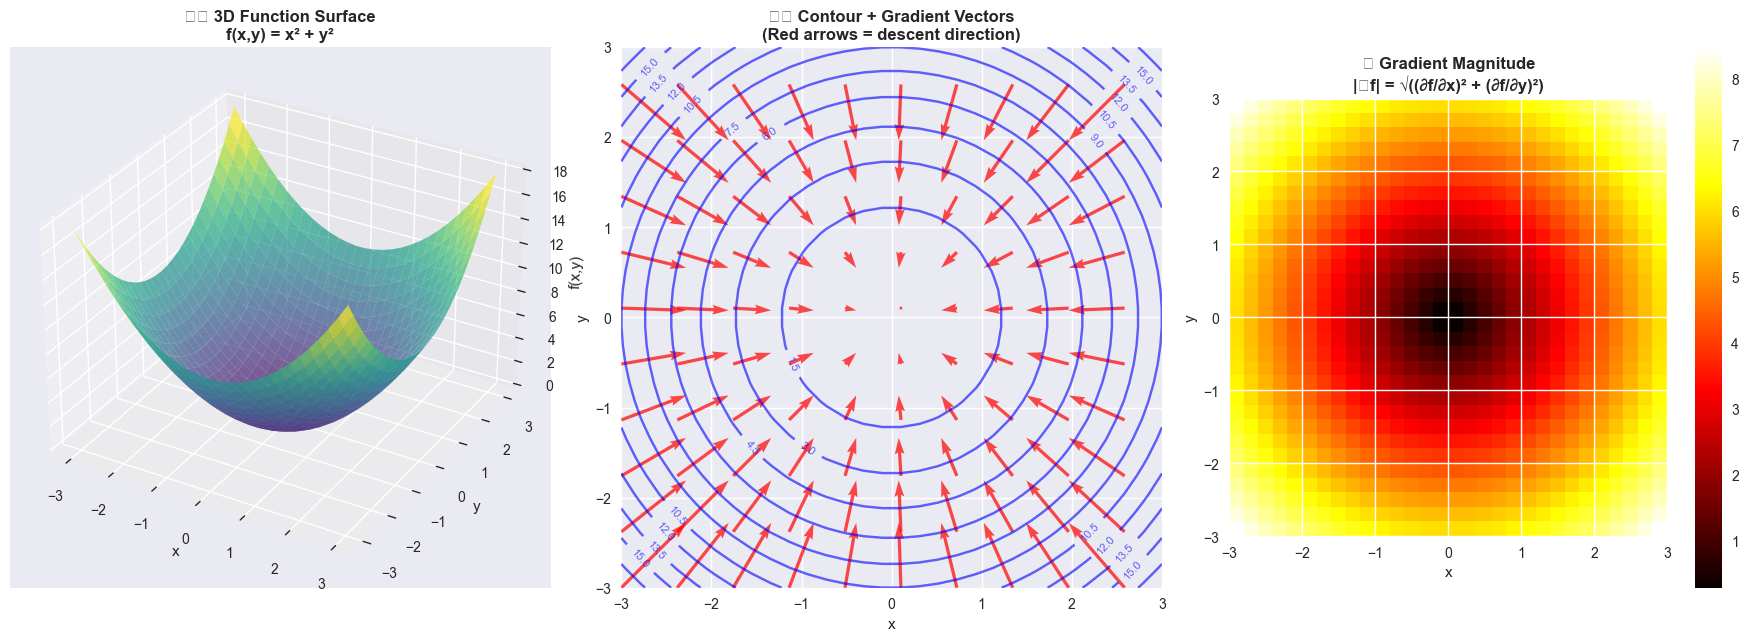

🎯 Key Insights:
   🏔️ Function surface shows the 'landscape' our model needs to navigate
   🧭 Red arrows point in steepest DESCENT direction (where we want to go!)
   🔥 Gradient magnitude shows how 'steep' the slope is at each point
   🎯 At the center (0,0), gradient = [0,0] → we found the minimum!


In [21]:
def visualize_2d_gradient():
    """Visualize gradients in 2D with contour plots and vector fields"""

    # Create a 2D function: f(x,y) = x² + y² (bowl shape)
    x = np.linspace(-3, 3, 30)
    y = np.linspace(-3, 3, 30)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + Y**2

    # Compute gradients: ∇f = [2x, 2y]
    dZ_dx = 2 * X
    dZ_dy = 2 * Y

    fig = plt.figure(figsize=(18, 6))

    # Plot 1: 3D surface
    ax1 = fig.add_subplot(131, projection="3d")
    surf = ax1.plot_surface(X, Y, Z, cmap="viridis", alpha=0.7)
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("f(x,y)")
    ax1.set_title("🏔️ 3D Function Surface\nf(x,y) = x² + y²", fontweight="bold")

    # Plot 2: Contour with gradient vectors
    ax2 = fig.add_subplot(132)
    contour = ax2.contour(X, Y, Z, levels=15, colors="blue", alpha=0.6)
    ax2.clabel(contour, inline=True, fontsize=8)

    # Show gradient vectors (downsampled for clarity)
    skip = 3
    ax2.quiver(
        X[::skip, ::skip],
        Y[::skip, ::skip],
        -dZ_dx[::skip, ::skip],
        -dZ_dy[::skip, ::skip],  # Negative for descent direction
        color="red",
        alpha=0.7,
        scale=50,
    )

    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_title(
        "🗺️ Contour + Gradient Vectors\n(Red arrows = descent direction)",
        fontweight="bold",
    )
    ax2.set_aspect("equal")

    # Plot 3: Gradient magnitude
    ax3 = fig.add_subplot(133)
    gradient_magnitude = np.sqrt(dZ_dx**2 + dZ_dy**2)
    im = ax3.imshow(
        gradient_magnitude, extent=[-3, 3, -3, 3], origin="lower", cmap="hot"
    )
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_title(
        "🔥 Gradient Magnitude\n|∇f| = √((∂f/∂x)² + (∂f/∂y)²)", fontweight="bold"
    )
    plt.colorbar(im, ax=ax3)

    plt.tight_layout()
    plt.show()

    print("🎯 Key Insights:")
    print("   🏔️ Function surface shows the 'landscape' our model needs to navigate")
    print("   🧭 Red arrows point in steepest DESCENT direction (where we want to go!)")
    print("   🔥 Gradient magnitude shows how 'steep' the slope is at each point")
    print("   🎯 At the center (0,0), gradient = [0,0] → we found the minimum!")


# Visualize 2D gradients
visualize_2d_gradient()

## 🔄 Computational Graphs: PyTorch's Secret Weapon

PyTorch builds a **computational graph** behind the scenes to track operations and compute gradients automatically!

### 🏗️ How It Works:

1. **Forward Pass**: Build the graph while computing function values
2. **Backward Pass**: Traverse graph in reverse to compute gradients
3. **Chain Rule**: Automatically applies chain rule at each node

Let's see this in action! 🚀


In [22]:
def demonstrate_computational_graph():
    """Show how PyTorch builds computational graphs"""

    print("🏗️ Building a Simple Computational Graph")
    print("=" * 50)

    # Create tensors with gradient tracking
    x = torch.tensor(2.0, requires_grad=True)
    y = torch.tensor(3.0, requires_grad=True)

    print(f"📊 Input tensors:")
    print(f"   x = {x.item():.2f} (requires_grad={x.requires_grad})")
    print(f"   y = {y.item():.2f} (requires_grad={y.requires_grad})")

    # Build computational graph step by step
    print(f"\n🔄 Forward pass (building the graph):")

    # Step 1: z = x * y
    z = x * y
    print(f"   Step 1: z = x * y = {z.item():.2f}")
    print(f"           Graph node: {z.grad_fn}")

    # Step 2: w = z + x
    w = z + x
    print(f"   Step 2: w = z + x = {w.item():.2f}")
    print(f"           Graph node: {w.grad_fn}")

    # Step 3: loss = w²
    loss = w**2
    print(f"   Step 3: loss = w² = {loss.item():.2f}")
    print(f"           Graph node: {loss.grad_fn}")

    # Backward pass
    print(f"\n⬅️ Backward pass (computing gradients):")
    loss.backward()

    print(f"   ∂loss/∂x = {x.grad.item():.2f}")
    print(f"   ∂loss/∂y = {y.grad.item():.2f}")

    # Manual verification
    print(f"\n🧮 Manual verification:")
    print(f"   loss = (x*y + x)² = (x*(y+1))²")
    print(
        f"   ∂loss/∂x = 2*x*(y+1)*(y+1) = 2*x*(y+1)² = 2*{x.item()}*{(y.item()+1)**2} = {2*x.item()*(y.item()+1)**2:.2f} ✅"
    )
    print(
        f"   ∂loss/∂y = 2*x*(y+1)*x = 2*x²*(y+1) = 2*{x.item()**2}*{(y.item()+1)} = {2*x.item()**2*(y.item()+1):.2f} ✅"
    )


demonstrate_computational_graph()

🏗️ Building a Simple Computational Graph
📊 Input tensors:
   x = 2.00 (requires_grad=True)
   y = 3.00 (requires_grad=True)

🔄 Forward pass (building the graph):
   Step 1: z = x * y = 6.00
           Graph node: <MulBackward0 object at 0x161c763e0>
   Step 2: w = z + x = 8.00
           Graph node: <AddBackward0 object at 0x161c763e0>
   Step 3: loss = w² = 64.00
           Graph node: <PowBackward0 object at 0x161c763e0>

⬅️ Backward pass (computing gradients):
   ∂loss/∂x = 64.00
   ∂loss/∂y = 32.00

🧮 Manual verification:
   loss = (x*y + x)² = (x*(y+1))²
   ∂loss/∂x = 2*x*(y+1)*(y+1) = 2*x*(y+1)² = 2*2.0*16.0 = 64.00 ✅
   ∂loss/∂y = 2*x*(y+1)*x = 2*x²*(y+1) = 2*4.0*4.0 = 32.00 ✅


In [23]:
def gradient_accumulation_demo():
    """Demonstrate gradient accumulation behavior"""

    print("📈 Gradient Accumulation Demo")
    print("=" * 40)

    x = torch.tensor(2.0, requires_grad=True)

    print(f"📊 Initial state:")
    print(f"   x = {x.item()}, x.grad = {x.grad}")

    print(f"\n🔄 Multiple backward passes:")

    # First backward pass
    y1 = x**2  # dy1/dx = 2x
    y1.backward()
    print(f"   After y₁ = x²: x.grad = {x.grad.item():.2f}")

    # Second backward pass (accumulates!)
    y2 = 3 * x  # dy2/dx = 3
    y2.backward()
    print(f"   After y₂ = 3x: x.grad = {x.grad.item():.2f} (accumulated!)")

    # Third backward pass
    y3 = x + 1  # dy3/dx = 1
    y3.backward()
    print(f"   After y₃ = x+1: x.grad = {x.grad.item():.2f} (accumulated!)")

    print(
        f"\n🧮 Expected: 2x + 3 + 1 = 2({x.item()}) + 3 + 1 = {2*x.item() + 3 + 1:.2f} ✅"
    )

    # Reset gradients
    print(f"\n🔄 Resetting gradients:")
    x.grad.zero_()  # or x.grad = None
    print(f"   After reset: x.grad = {x.grad}")


gradient_accumulation_demo()

📈 Gradient Accumulation Demo
📊 Initial state:
   x = 2.0, x.grad = None

🔄 Multiple backward passes:
   After y₁ = x²: x.grad = 4.00
   After y₂ = 3x: x.grad = 7.00 (accumulated!)
   After y₃ = x+1: x.grad = 8.00 (accumulated!)

🧮 Expected: 2x + 3 + 1 = 2(2.0) + 3 + 1 = 8.00 ✅

🔄 Resetting gradients:
   After reset: x.grad = 0.0


🎯 Gradient-Based Optimization Visualization
🚀 Starting optimization from (-1.00, 2.00)
   Step  0: (-1.000,  2.000) → Loss:  9.5977 → Grad: (-6.595,  3.304)
   Step  1: (-0.340,  1.670) → Loss:  6.1613 → Grad: (-4.525,  3.521)
   Step  2: ( 0.112,  1.317) → Loss:  3.9187 → Grad: (-1.755,  0.237)
   Step  3: ( 0.288,  1.294) → Loss:  3.5058 → Grad: (-3.099,  0.130)
   Step  4: ( 0.597,  1.281) → Loss:  2.1222 → Grad: (-5.258,  0.515)
   Step  5: ( 1.123,  1.229) → Loss:  0.5148 → Grad: ( 0.192,  0.246)
   Step  6: ( 1.104,  1.205) → Loss:  0.5107 → Grad: (-0.046, -0.036)
   Step  7: ( 1.109,  1.208) → Loss:  0.5106 → Grad: ( 0.009,  0.011)
   Step  8: ( 1.108,  1.207) → Loss:  0.5106 → Grad: (-0.003, -0.002)
   Step  9: ( 1.108,  1.207) → Loss:  0.5106 → Grad: ( 0.001,  0.001)

🏁 Final position: (1.108, 1.207)
🎯 Target (global minimum): (2.000, 1.000)


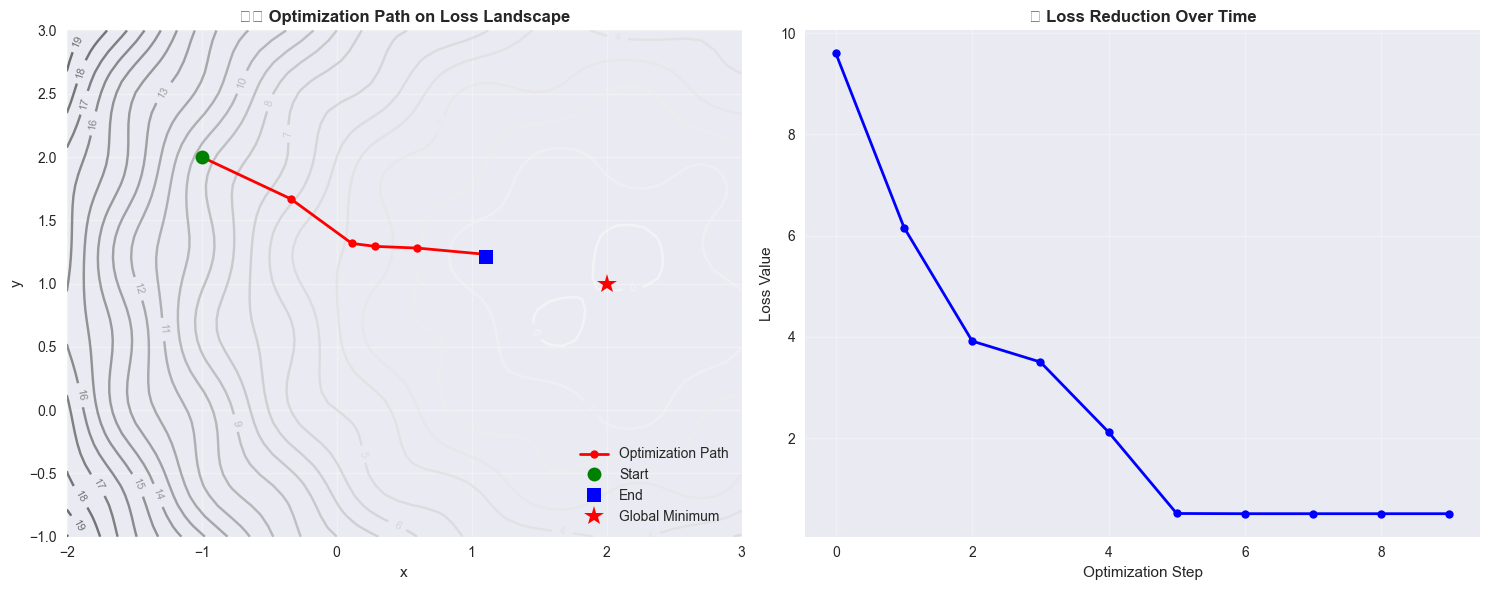


🎓 Key Insights:
   📐 Gradients point in direction of steepest ASCENT
   ⬇️ We move in OPPOSITE direction to minimize loss
   📏 Learning rate controls step size
   🎯 Gradients get smaller as we approach minimum


In [24]:
def optimization_visualization():
    """Visualize how gradients guide optimization"""

    print("🎯 Gradient-Based Optimization Visualization")
    print("=" * 50)

    # Define a 2D function to optimize
    def func(x, y):
        return (x - 2) ** 2 + (y - 1) ** 2 + 0.5 * torch.sin(5 * x) * torch.cos(5 * y)

    # Starting point
    x = torch.tensor(-1.0, requires_grad=True)
    y = torch.tensor(2.0, requires_grad=True)
    learning_rate = 0.1

    # Track optimization path
    path_x, path_y, losses = [], [], []

    print(f"🚀 Starting optimization from ({x.item():.2f}, {y.item():.2f})")

    for step in range(10):
        # Zero gradients
        if x.grad is not None:
            x.grad.zero_()
        if y.grad is not None:
            y.grad.zero_()

        # Forward pass
        loss = func(x, y)

        # Backward pass
        loss.backward()

        # Store current state
        path_x.append(x.item())
        path_y.append(y.item())
        losses.append(loss.item())

        print(
            f"   Step {step:2d}: ({x.item():6.3f}, {y.item():6.3f}) → Loss: {loss.item():7.4f} → Grad: ({x.grad.item():6.3f}, {y.grad.item():6.3f})"
        )

        # Update parameters
        with torch.inference_mode():
            x -= learning_rate * x.grad
            y -= learning_rate * y.grad

    print(f"\n🏁 Final position: ({x.item():.3f}, {y.item():.3f})")
    print(f"🎯 Target (global minimum): (2.000, 1.000)")

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Function contour with optimization path
    x_range = np.linspace(-2, 3, 50)
    y_range = np.linspace(-1, 3, 50)
    X, Y = np.meshgrid(x_range, y_range)

    # Compute function values
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(torch.tensor(X[i, j]), torch.tensor(Y[i, j])).item()

    # Contour plot
    contour = ax1.contour(X, Y, Z, levels=20, alpha=0.6)
    ax1.clabel(contour, inline=True, fontsize=8)

    # Plot optimization path
    ax1.plot(
        path_x, path_y, "ro-", linewidth=2, markersize=6, label="Optimization Path"
    )
    ax1.plot(path_x[0], path_y[0], "go", markersize=10, label="Start")
    ax1.plot(path_x[-1], path_y[-1], "bs", markersize=10, label="End")
    ax1.plot(2, 1, "r*", markersize=15, label="Global Minimum")

    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_title("🗺️ Optimization Path on Loss Landscape", fontweight="bold")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Loss over time
    ax2.plot(range(len(losses)), losses, "b-o", linewidth=2, markersize=6)
    ax2.set_xlabel("Optimization Step")
    ax2.set_ylabel("Loss Value")
    ax2.set_title("📉 Loss Reduction Over Time", fontweight="bold")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n🎓 Key Insights:")
    print(f"   📐 Gradients point in direction of steepest ASCENT")
    print(f"   ⬇️ We move in OPPOSITE direction to minimize loss")
    print(f"   📏 Learning rate controls step size")
    print(f"   🎯 Gradients get smaller as we approach minimum")


optimization_visualization()

In [25]:
def tensor_gradients_demo():
    """Demonstrate gradients with multi-dimensional tensors"""

    print("🔢 Multi-Dimensional Tensor Gradients")
    print("=" * 45)

    # Create multi-dimensional tensors
    x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)
    y = torch.tensor([[2.0, 1.0], [1.0, 2.0]], requires_grad=True)

    print(f"📊 Input tensors:")
    print(f"   x = \n{x}")
    print(f"   y = \n{y}")

    # Compute element-wise operations
    z = x * y  # Element-wise multiplication
    w = z.sum()  # Sum all elements to get scalar

    print(f"\n🔄 Operations:")
    print(f"   z = x ⊙ y = \n{z}")
    print(f"   w = sum(z) = {w.item():.2f}")

    # Compute gradients
    w.backward()

    print(f"\n⬅️ Gradients:")
    print(f"   ∂w/∂x = \n{x.grad}")
    print(f"   ∂w/∂y = \n{y.grad}")

    print(f"\n🧮 Manual verification:")
    print(f"   Since w = sum(x ⊙ y), we have:")
    print(f"   ∂w/∂x[i,j] = y[i,j] and ∂w/∂y[i,j] = x[i,j]")
    print(f"   Expected ∂w/∂x = y = \n{y}")
    print(f"   Expected ∂w/∂y = x = \n{x}")


tensor_gradients_demo()

🔢 Multi-Dimensional Tensor Gradients
📊 Input tensors:
   x = 
tensor([[1., 2.],
        [3., 4.]], requires_grad=True)
   y = 
tensor([[2., 1.],
        [1., 2.]], requires_grad=True)

🔄 Operations:
   z = x ⊙ y = 
tensor([[2., 2.],
        [3., 8.]], grad_fn=<MulBackward0>)
   w = sum(z) = 15.00

⬅️ Gradients:
   ∂w/∂x = 
tensor([[2., 1.],
        [1., 2.]])
   ∂w/∂y = 
tensor([[1., 2.],
        [3., 4.]])

🧮 Manual verification:
   Since w = sum(x ⊙ y), we have:
   ∂w/∂x[i,j] = y[i,j] and ∂w/∂y[i,j] = x[i,j]
   Expected ∂w/∂x = y = 
tensor([[2., 1.],
        [1., 2.]], requires_grad=True)
   Expected ∂w/∂y = x = 
tensor([[1., 2.],
        [3., 4.]], requires_grad=True)


## Understanding requires_grad

The `requires_grad` parameter controls whether PyTorch should track operations for gradient computation.


In [26]:
# Tensors with and without gradient tracking
a = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(3.0, requires_grad=False)
c = torch.tensor(4.0)  # requires_grad=False by default

print(f"a.requires_grad: {a.requires_grad}")
print(f"b.requires_grad: {b.requires_grad}")
print(f"c.requires_grad: {c.requires_grad}")

# Operations inherit gradient requirements
result1 = a * b  # Result requires grad because a does
result2 = b * c  # Result doesn't require grad because neither b nor c do

print(f"(a * b).requires_grad: {result1.requires_grad}")
print(f"(b * c).requires_grad: {result2.requires_grad}")

a.requires_grad: True
b.requires_grad: False
c.requires_grad: False
(a * b).requires_grad: True
(b * c).requires_grad: False


## Detaching from the Computational Graph

Sometimes you want to stop gradient computation for certain operations.


In [27]:
x = torch.tensor(2.0, requires_grad=True)

# Normal computation
y1 = x**2
print(f"y1.requires_grad: {y1.requires_grad}")

# Detached computation
y2 = x.detach() ** 2
print(f"y2.requires_grad: {y2.requires_grad}")

# Using torch.inference_mode() (preferred over torch.inference_mode())
with torch.inference_mode():
    y3 = x**2
    print(f"y3.requires_grad: {y3.requires_grad}")

# The detached tensor shares storage but not gradient history
print(f"x.data_ptr() == x.detach().data_ptr(): {x.data_ptr() == x.detach().data_ptr()}")

y1.requires_grad: True
y2.requires_grad: False
y3.requires_grad: False
x.data_ptr() == x.detach().data_ptr(): True


## Neural Network Example: Manual Implementation

Let's implement a simple neural network manually to see autograd in action.


Epoch 0, Loss: 1.1897
Epoch 20, Loss: 0.7134
Epoch 40, Loss: 0.5733
Epoch 60, Loss: 0.4824
Epoch 80, Loss: 0.4119


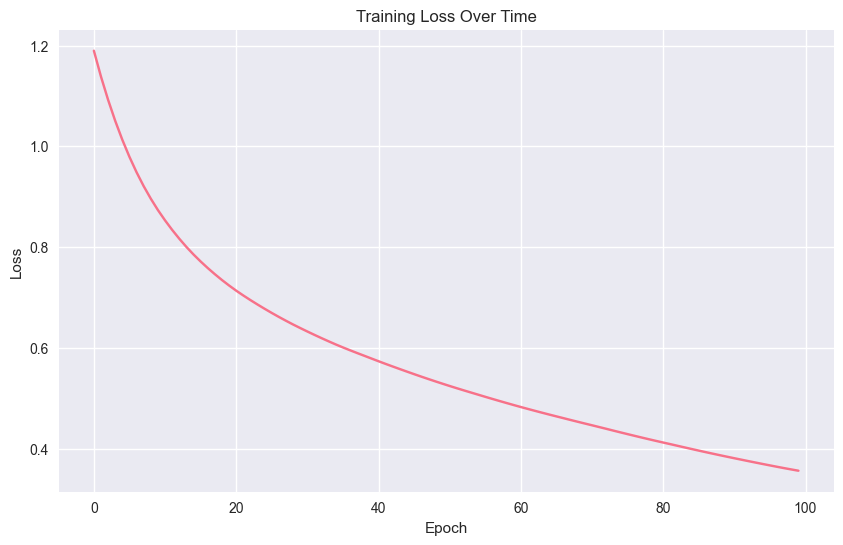

In [28]:
# Create a simple dataset
torch.manual_seed(42)
X = torch.randn(100, 2)  # 100 samples, 2 features
y = (X[:, 0] + X[:, 1] > 0).float().unsqueeze(1)  # Simple classification

# Manual neural network parameters
W1 = torch.randn(2, 5, requires_grad=True)  # Input to hidden
b1 = torch.zeros(5, requires_grad=True)  # Hidden bias
W2 = torch.randn(5, 1, requires_grad=True)  # Hidden to output
b2 = torch.zeros(1, requires_grad=True)  # Output bias


def forward(X):
    """Forward pass through the network"""
    h = torch.relu(X @ W1 + b1)  # Hidden layer
    out = torch.sigmoid(h @ W2 + b2)  # Output layer
    return out


def compute_loss(predictions, targets):
    """Binary cross-entropy loss"""
    return -torch.mean(
        targets * torch.log(predictions + 1e-8)
        + (1 - targets) * torch.log(1 - predictions + 1e-8)
    )


# Training loop
learning_rate = 0.1
losses = []

for epoch in range(100):
    # Forward pass
    predictions = forward(X)
    loss = compute_loss(predictions, y)

    # Backward pass
    loss.backward()

    # Update parameters manually
    with torch.inference_mode():
        W1 -= learning_rate * W1.grad
        b1 -= learning_rate * b1.grad
        W2 -= learning_rate * W2.grad
        b2 -= learning_rate * b2.grad

    # Clear gradients
    W1.grad = None
    b1.grad = None
    W2.grad = None
    b2.grad = None

    losses.append(loss.item())

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title("Training Loss Over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Gradient Accumulation for Large Batches

When memory is limited, you can simulate larger batch sizes by accumulating gradients across multiple smaller batches.


In [29]:
# Simulate gradient accumulation
from torch import nn

model = nn.Linear(10, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Create some dummy data
X = torch.randn(100, 10)
y = torch.randn(100, 1)

accumulation_steps = 4
batch_size = 8

for epoch in range(5):
    total_loss = 0
    optimizer.zero_grad()  # Clear gradients at the start of each epoch

    for i in range(0, len(X), batch_size):
        # Get mini-batch
        batch_X = X[i : i + batch_size]
        batch_y = y[i : i + batch_size]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Scale loss by accumulation steps
        loss = loss / accumulation_steps

        # Backward pass (accumulates gradients)
        loss.backward()

        total_loss += loss.item()

        # Update parameters every accumulation_steps
        if (i // batch_size + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch+1}, Average Loss: {total_loss:.4f}")

Epoch 1, Average Loss: 4.9993
Epoch 2, Average Loss: 4.8793
Epoch 3, Average Loss: 4.7709
Epoch 4, Average Loss: 4.6728
Epoch 5, Average Loss: 4.5839


## Custom Autograd Functions

For advanced use cases, you can define custom autograd functions with custom forward and backward passes.


In [30]:
class SquareFunction(torch.autograd.Function):
    """
    Custom autograd function that squares its input.
    This example shows how to define custom forward and backward passes.
    """

    @staticmethod
    def forward(ctx, input):
        """
        Forward pass: compute the output
        ctx: context object to save information for backward pass
        """
        ctx.save_for_backward(input)  # Save input for backward pass
        return input * input

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass: compute gradient with respect to input
        grad_output: gradient flowing back from the next layer
        """
        (input,) = ctx.saved_tensors  # Retrieve saved input
        grad_input = grad_output * 2 * input  # d/dx(x^2) = 2x
        return grad_input


# Use the custom function
square = SquareFunction.apply

x = torch.tensor(3.0, requires_grad=True)
y = square(x)
print(f"y = {y}")

y.backward()
print(f"dy/dx = {x.grad}")  # Should be 2*3 = 6

y = 9.0
dy/dx = 6.0


## 🛠️ Advanced AutoGrad Techniques

Let's explore some advanced features that make PyTorch's autograd system so powerful!


In [31]:
def higher_order_gradients():
    """Demonstrate second-order gradients (gradients of gradients)"""

    print("📈 Higher-Order Gradients Demo")
    print("=" * 35)

    # Create input with gradient tracking
    x = torch.tensor(2.0, requires_grad=True)

    # Define function: f(x) = x⁴ + 2x³ + x²
    y = x**4 + 2 * x**3 + x**2

    print(f"📊 Function: f(x) = x⁴ + 2x³ + x²")
    print(f"   At x = {x.item()}: f(x) = {y.item():.2f}")

    # First derivative: f'(x) = 4x³ + 6x² + 2x
    first_grad = torch.autograd.grad(y, x, create_graph=True)[0]
    print(f"\n📐 First derivative: f'(x) = 4x³ + 6x² + 2x")
    print(f"   f'({x.item()}) = {first_grad.item():.2f}")

    # Second derivative: f''(x) = 12x² + 12x + 2
    second_grad = torch.autograd.grad(first_grad, x)[0]
    print(f"\n📐📐 Second derivative: f''(x) = 12x² + 12x + 2")
    print(f"   f''({x.item()}) = {second_grad.item():.2f}")

    # Manual verification
    x_val = x.item()
    manual_first = 4 * x_val**3 + 6 * x_val**2 + 2 * x_val
    manual_second = 12 * x_val**2 + 12 * x_val + 2

    print(f"\n🧮 Manual verification:")
    print(f"   f'({x_val}) = {manual_first:.2f} ✅")
    print(f"   f''({x_val}) = {manual_second:.2f} ✅")

    print(f"\n💡 Applications of higher-order gradients:")
    print(f"   🎯 Newton's optimization method")
    print(f"   🔍 Curvature analysis")
    print(f"   🧠 Meta-learning algorithms")


higher_order_gradients()

📈 Higher-Order Gradients Demo
📊 Function: f(x) = x⁴ + 2x³ + x²
   At x = 2.0: f(x) = 36.00

📐 First derivative: f'(x) = 4x³ + 6x² + 2x
   f'(2.0) = 60.00

📐📐 Second derivative: f''(x) = 12x² + 12x + 2
   f''(2.0) = 74.00

🧮 Manual verification:
   f'(2.0) = 60.00 ✅
   f''(2.0) = 74.00 ✅

💡 Applications of higher-order gradients:
   🎯 Newton's optimization method
   🔍 Curvature analysis
   🧠 Meta-learning algorithms


In [32]:
def custom_autograd_function():
    """Demonstrate how to create custom autograd functions"""

    print("\n🔧 Custom AutoGrad Function")
    print("=" * 35)

    class MyReLU(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input):
            # Save input for backward pass
            ctx.save_for_backward(input)
            return input.clamp(min=0)

        @staticmethod
        def backward(ctx, grad_output):
            # Retrieve saved input
            (input,) = ctx.saved_tensors
            grad_input = grad_output.clone()
            grad_input[input < 0] = 0  # Gradient is 0 where input < 0
            return grad_input

    # Use our custom function
    x = torch.tensor([-2.0, -1.0, 0.0, 1.0, 2.0], requires_grad=True)

    print(f"📊 Input: {x}")

    # Apply custom ReLU
    y = MyReLU.apply(x)
    print(f"   Custom ReLU output: {y}")

    # Compute gradient
    loss = y.sum()
    loss.backward()

    print(f"   Gradients: {x.grad}")
    print(f"   Expected: [0, 0, 0, 1, 1] (gradient is 1 where input > 0, else 0)")

    print(f"\n💡 Custom functions are useful for:")
    print(f"   ⚡ Implementing new operations")
    print(f"   🔧 Optimizing performance")
    print(f"   🎛️ Controlling gradient flow")


custom_autograd_function()


🔧 Custom AutoGrad Function
📊 Input: tensor([-2., -1.,  0.,  1.,  2.], requires_grad=True)
   Custom ReLU output: tensor([0., 0., 0., 1., 2.], grad_fn=<MyReLUBackward>)
   Gradients: tensor([0., 0., 1., 1., 1.])
   Expected: [0, 0, 0, 1, 1] (gradient is 1 where input > 0, else 0)

💡 Custom functions are useful for:
   ⚡ Implementing new operations
   🔧 Optimizing performance
   🎛️ Controlling gradient flow


## 🐛 Debugging Gradients: Common Issues and Solutions

Let's learn how to debug gradient-related problems!


In [33]:
def gradient_debugging():
    """Demonstrate common gradient issues and how to debug them"""

    print("🐛 Gradient Debugging Guide")
    print("=" * 35)

    # Issue 1: In-place operations
    print("⚠️  Issue 1: In-place operations break gradients")
    x = torch.tensor(2.0, requires_grad=True)
    y = x**2

    try:
        y += 1  # This is in-place!
        y.backward()
    except RuntimeError as e:
        print(f"   Error: {str(e)[:60]}...")
        print(f"   🔧 Solution: Use y = y + 1 instead of y += 1")

    # Issue 2: Missing requires_grad
    print(f"\n⚠️  Issue 2: Missing requires_grad")
    x1 = torch.tensor(2.0)  # No requires_grad!
    y1 = x1**2
    print(f"   x.requires_grad: {x1.requires_grad}")
    print(f"   y.requires_grad: {y1.requires_grad}")
    print(f"   🔧 Solution: Set requires_grad=True or use x.requires_grad_(True)")

    # Issue 3: Detached computation graph
    print(f"\n⚠️  Issue 3: Accidentally detaching computation graph")
    x2 = torch.tensor(2.0, requires_grad=True)
    y2 = x2**2
    y2_detached = y2.detach()  # Breaks the graph!
    z2 = y2_detached * 2
    print(f"   z.requires_grad: {z2.requires_grad}")
    print(f"   🔧 Solution: Don't use .detach() unless intended")

    # Issue 4: Multiple backward passes without retain_graph
    print(f"\n⚠️  Issue 4: Multiple backward passes")
    x3 = torch.tensor(2.0, requires_grad=True)
    y3 = x3**2

    y3.backward(retain_graph=True)  # First backward
    print(f"   First backward: x.grad = {x3.grad}")

    y3.backward()  # Second backward (possible with retain_graph=True)
    print(f"   Second backward: x.grad = {x3.grad} (accumulated!)")

    print(f"\n🔧 Debugging tools:")
    print(f"   🔍 Check requires_grad property")
    print(f"   🔍 Inspect grad_fn attribute")
    print(f"   🔍 Use torch.autograd.grad() for more control")
    print(f"   🔍 Use torch.autograd.gradcheck() for testing")


gradient_debugging()

🐛 Gradient Debugging Guide
⚠️  Issue 1: In-place operations break gradients

⚠️  Issue 2: Missing requires_grad
   x.requires_grad: False
   y.requires_grad: False
   🔧 Solution: Set requires_grad=True or use x.requires_grad_(True)

⚠️  Issue 3: Accidentally detaching computation graph
   z.requires_grad: False
   🔧 Solution: Don't use .detach() unless intended

⚠️  Issue 4: Multiple backward passes
   First backward: x.grad = 4.0
   Second backward: x.grad = 8.0 (accumulated!)

🔧 Debugging tools:
   🔍 Check requires_grad property
   🔍 Inspect grad_fn attribute
   🔍 Use torch.autograd.grad() for more control
   🔍 Use torch.autograd.gradcheck() for testing


## 🎓 Summary and Best Practices

Let's wrap up with key takeaways and best practices for using gradients effectively!


In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
import warnings

warnings.filterwarnings("ignore")

# Set style for professional plots
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("🚀 Gradient and AutoGrad Learning Environment Ready!")
print("📚 Let's explore the magic behind automatic differentiation!")

🚀 Gradient and AutoGrad Learning Environment Ready!
📚 Let's explore the magic behind automatic differentiation!


## 🎨 Visualizing Gradients: From Simple to Complex

Let's start with visual intuition before diving into code!


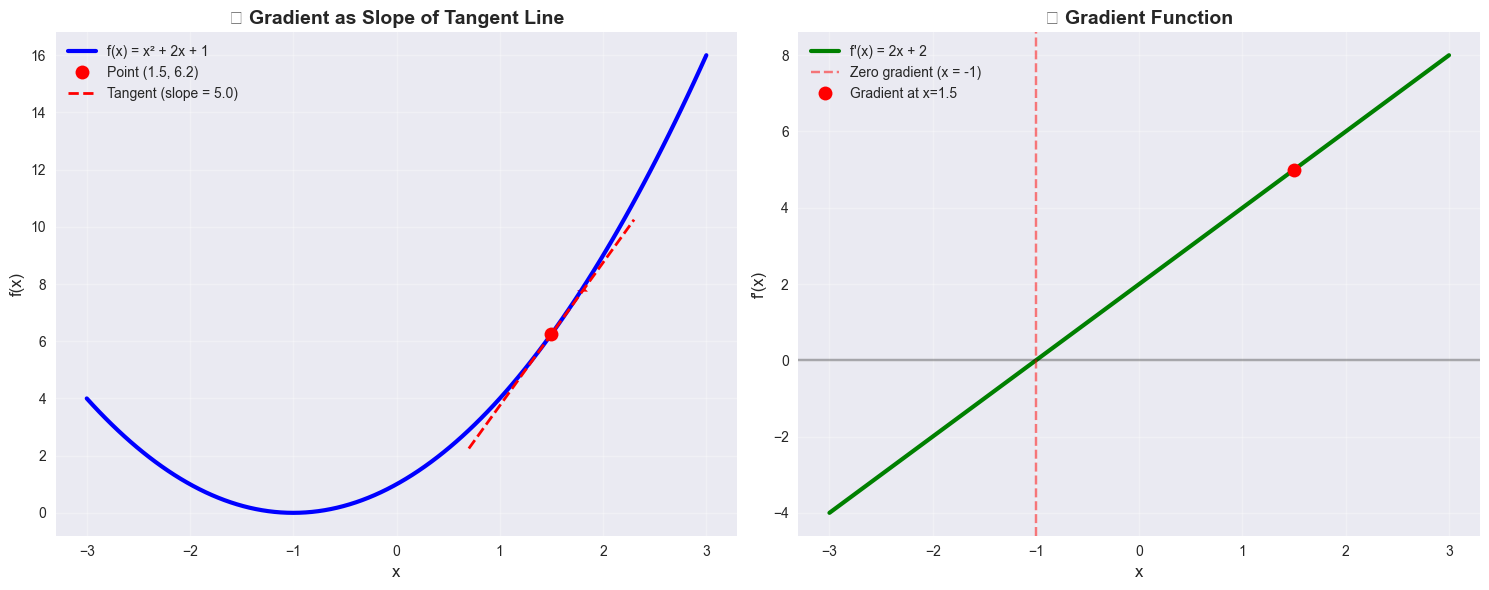

🎯 At x = 1.5:
   📊 Function value: f(1.5) = 6.25
   📐 Gradient: f'(1.5) = 5.00
   🧭 Direction: Increasing


In [35]:
def visualize_1d_gradient():
    """Visualize gradient as slope on a 1D function"""

    # Create a simple quadratic function
    x = np.linspace(-3, 3, 100)
    y = x**2 + 2 * x + 1  # f(x) = x² + 2x + 1

    # Analytical gradient: f'(x) = 2x + 2
    gradient = 2 * x + 2

    # Pick a point to show tangent
    point_x = 1.5
    point_y = point_x**2 + 2 * point_x + 1
    point_grad = 2 * point_x + 2

    # Create tangent line
    tangent_x = np.linspace(point_x - 0.8, point_x + 0.8, 10)
    tangent_y = point_y + point_grad * (tangent_x - point_x)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Function with tangent line
    ax1.plot(x, y, "b-", linewidth=3, label="f(x) = x² + 2x + 1")
    ax1.plot(
        point_x,
        point_y,
        "ro",
        markersize=10,
        label=f"Point ({point_x:.1f}, {point_y:.1f})",
    )
    ax1.plot(
        tangent_x,
        tangent_y,
        "r--",
        linewidth=2,
        label=f"Tangent (slope = {point_grad:.1f})",
    )

    # Add arrow showing gradient direction
    arrow_scale = 0.3
    ax1.arrow(
        point_x,
        point_y,
        arrow_scale,
        point_grad * arrow_scale,
        head_width=0.1,
        head_length=0.1,
        fc="red",
        ec="red",
    )

    ax1.set_xlabel("x", fontsize=12)
    ax1.set_ylabel("f(x)", fontsize=12)
    ax1.set_title(
        "🔍 Gradient as Slope of Tangent Line", fontsize=14, fontweight="bold"
    )
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Gradient function
    ax2.plot(x, gradient, "g-", linewidth=3, label="f'(x) = 2x + 2")
    ax2.axhline(y=0, color="k", linestyle="-", alpha=0.3)
    ax2.axvline(
        x=-1, color="r", linestyle="--", alpha=0.5, label="Zero gradient (x = -1)"
    )
    ax2.plot(
        point_x, point_grad, "ro", markersize=10, label=f"Gradient at x={point_x:.1f}"
    )

    ax2.set_xlabel("x", fontsize=12)
    ax2.set_ylabel("f'(x)", fontsize=12)
    ax2.set_title("📈 Gradient Function", fontsize=14, fontweight="bold")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"🎯 At x = {point_x}:")
    print(f"   📊 Function value: f({point_x}) = {point_y:.2f}")
    print(f"   📐 Gradient: f'({point_x}) = {point_grad:.2f}")
    print(
        f"   🧭 Direction: {'Increasing' if point_grad > 0 else 'Decreasing' if point_grad < 0 else 'Flat'}"
    )


# Visualize 1D gradients
visualize_1d_gradient()

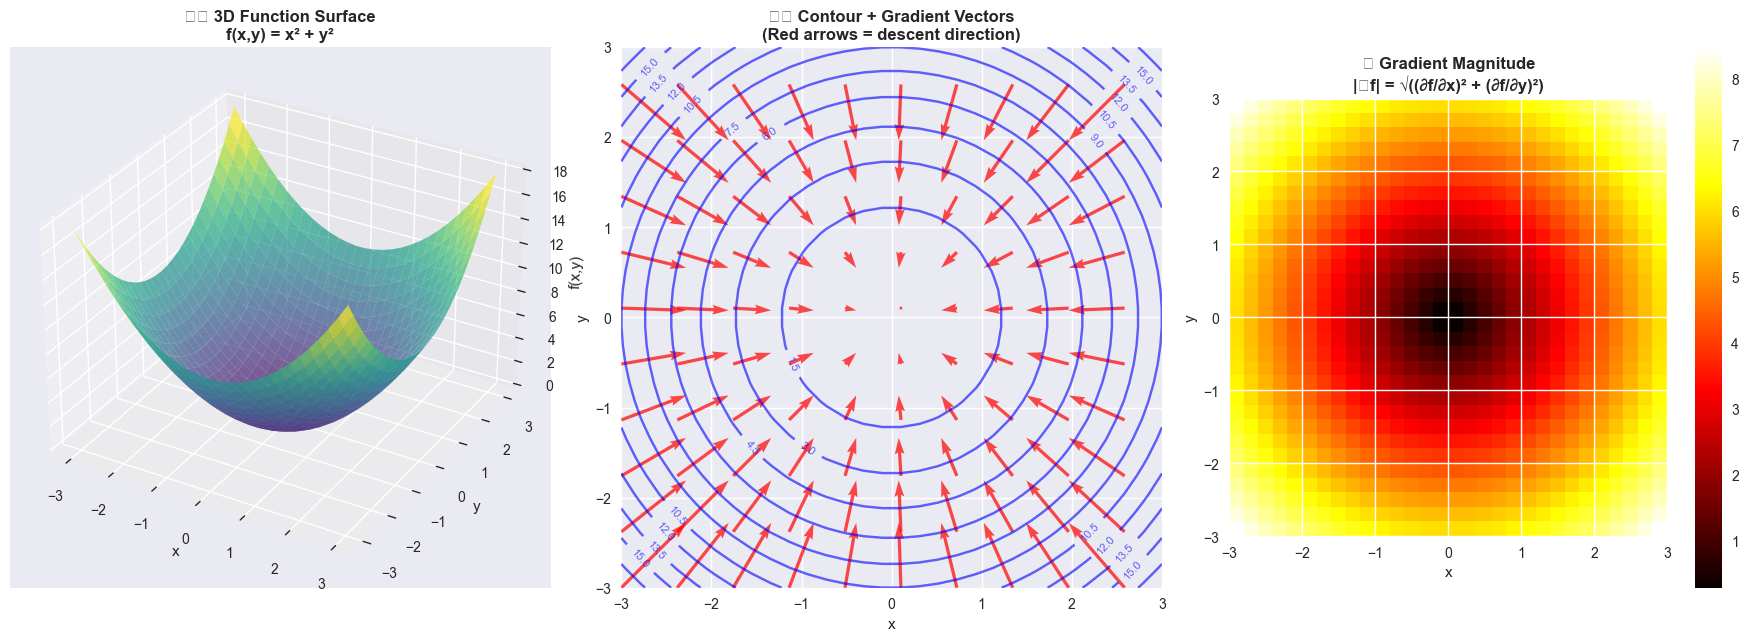

🎯 Key Insights:
   🏔️ Function surface shows the 'landscape' our model needs to navigate
   🧭 Red arrows point in steepest DESCENT direction (where we want to go!)
   🔥 Gradient magnitude shows how 'steep' the slope is at each point
   🎯 At the center (0,0), gradient = [0,0] → we found the minimum!


In [36]:
def visualize_2d_gradient():
    """Visualize gradients in 2D with contour plots and vector fields"""

    # Create a 2D function: f(x,y) = x² + y² (bowl shape)
    x = np.linspace(-3, 3, 30)
    y = np.linspace(-3, 3, 30)
    X, Y = np.meshgrid(x, y)
    Z = X**2 + Y**2

    # Compute gradients: ∇f = [2x, 2y]
    dZ_dx = 2 * X
    dZ_dy = 2 * Y

    fig = plt.figure(figsize=(18, 6))

    # Plot 1: 3D surface
    ax1 = fig.add_subplot(131, projection="3d")
    surf = ax1.plot_surface(X, Y, Z, cmap="viridis", alpha=0.7)
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.set_zlabel("f(x,y)")
    ax1.set_title("🏔️ 3D Function Surface\nf(x,y) = x² + y²", fontweight="bold")

    # Plot 2: Contour with gradient vectors
    ax2 = fig.add_subplot(132)
    contour = ax2.contour(X, Y, Z, levels=15, colors="blue", alpha=0.6)
    ax2.clabel(contour, inline=True, fontsize=8)

    # Show gradient vectors (downsampled for clarity)
    skip = 3
    ax2.quiver(
        X[::skip, ::skip],
        Y[::skip, ::skip],
        -dZ_dx[::skip, ::skip],
        -dZ_dy[::skip, ::skip],  # Negative for descent direction
        color="red",
        alpha=0.7,
        scale=50,
    )

    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_title(
        "🗺️ Contour + Gradient Vectors\n(Red arrows = descent direction)",
        fontweight="bold",
    )
    ax2.set_aspect("equal")

    # Plot 3: Gradient magnitude
    ax3 = fig.add_subplot(133)
    gradient_magnitude = np.sqrt(dZ_dx**2 + dZ_dy**2)
    im = ax3.imshow(
        gradient_magnitude, extent=[-3, 3, -3, 3], origin="lower", cmap="hot"
    )
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")
    ax3.set_title(
        "🔥 Gradient Magnitude\n|∇f| = √((∂f/∂x)² + (∂f/∂y)²)", fontweight="bold"
    )
    plt.colorbar(im, ax=ax3)

    plt.tight_layout()
    plt.show()

    print("🎯 Key Insights:")
    print("   🏔️ Function surface shows the 'landscape' our model needs to navigate")
    print("   🧭 Red arrows point in steepest DESCENT direction (where we want to go!)")
    print("   🔥 Gradient magnitude shows how 'steep' the slope is at each point")
    print("   🎯 At the center (0,0), gradient = [0,0] → we found the minimum!")


# Visualize 2D gradients
visualize_2d_gradient()

## 🔄 Computational Graphs: PyTorch's Secret Weapon

PyTorch builds a **computational graph** behind the scenes to track operations and compute gradients automatically!

### 🏗️ How It Works:

1. **Forward Pass**: Build the graph while computing function values
2. **Backward Pass**: Traverse graph in reverse to compute gradients
3. **Chain Rule**: Automatically applies chain rule at each node

Let's see this in action! 🚀


## 🚀 PyTorch AutoGrad in Action

Now let's see how PyTorch automatically computes gradients for us!


In [37]:
def simple_autograd_example():
    """Demonstrate basic automatic differentiation"""

    print("🔧 Simple AutoGrad Example")
    print("=" * 40)

    # Create tensor with gradient tracking
    x = torch.tensor(3.0, requires_grad=True)
    print(f"📊 Input: x = {x.item()}")
    print(f"   requires_grad: {x.requires_grad}")
    print(f"   grad_fn: {x.grad_fn}")  # None for leaf nodes

    # Define function: f(x) = x² + 2x + 1
    y = x**2 + 2 * x + 1
    print(f"\n🔄 Forward pass:")
    print(f"   y = x² + 2x + 1 = {y.item():.2f}")
    print(f"   y.grad_fn: {y.grad_fn}")
    print(f"   y.requires_grad: {y.requires_grad}")

    # Compute gradient
    print(f"\n⬅️ Backward pass:")
    y.backward()

    print(f"   dy/dx = {x.grad.item():.2f}")

    # Verify manually: dy/dx = 2x + 2
    manual_grad = 2 * x.item() + 2
    print(f"   Manual: dy/dx = 2x + 2 = 2({x.item()}) + 2 = {manual_grad:.2f} ✅")


simple_autograd_example()

🔧 Simple AutoGrad Example
📊 Input: x = 3.0
   requires_grad: True
   grad_fn: None

🔄 Forward pass:
   y = x² + 2x + 1 = 16.00
   y.grad_fn: <AddBackward0 object at 0x161c763e0>
   y.requires_grad: True

⬅️ Backward pass:
   dy/dx = 8.00
   Manual: dy/dx = 2x + 2 = 2(3.0) + 2 = 8.00 ✅


In [38]:
def multi_variable_autograd():
    """Demonstrate gradients with multiple variables"""

    print("\n🎲 Multi-Variable AutoGrad")
    print("=" * 40)

    # Create multiple tensors
    x = torch.tensor(2.0, requires_grad=True)
    y = torch.tensor(3.0, requires_grad=True)

    print(f"📊 Inputs:")
    print(f"   x = {x.item()}, y = {y.item()}")

    # Complex function: f(x,y) = x²y + xy² + 2x + 3y
    z = x**2 * y + x * y**2 + 2 * x + 3 * y

    print(f"\n🔄 Function: f(x,y) = x²y + xy² + 2x + 3y")
    print(f"   f({x.item()}, {y.item()}) = {z.item():.2f}")

    # Compute gradients
    z.backward()

    print(f"\n⬅️ Gradients:")
    print(f"   ∂f/∂x = {x.grad.item():.2f}")
    print(f"   ∂f/∂y = {y.grad.item():.2f}")

    # Manual verification
    # ∂f/∂x = 2xy + y² + 2
    # ∂f/∂y = x² + 2xy + 3
    manual_dx = 2 * x.item() * y.item() + y.item() ** 2 + 2
    manual_dy = x.item() ** 2 + 2 * x.item() * y.item() + 3

    print(f"\n🧮 Manual verification:")
    print(f"   ∂f/∂x = 2xy + y² + 2 = {manual_dx:.2f} ✅")
    print(f"   ∂f/∂y = x² + 2xy + 3 = {manual_dy:.2f} ✅")


multi_variable_autograd()


🎲 Multi-Variable AutoGrad
📊 Inputs:
   x = 2.0, y = 3.0

🔄 Function: f(x,y) = x²y + xy² + 2x + 3y
   f(2.0, 3.0) = 43.00

⬅️ Gradients:
   ∂f/∂x = 23.00
   ∂f/∂y = 19.00

🧮 Manual verification:
   ∂f/∂x = 2xy + y² + 2 = 23.00 ✅
   ∂f/∂y = x² + 2xy + 3 = 19.00 ✅


## 🔗 Chain Rule in Action

The real power of automatic differentiation comes from the **chain rule**! Let's see how PyTorch handles complex composite functions.


In [39]:
def chain_rule_demo():
    """Demonstrate chain rule with composite functions"""

    print("🔗 Chain Rule Demonstration")
    print("=" * 40)

    # Create input
    x = torch.tensor(2.0, requires_grad=True)

    # Build composite function step by step
    print(f"📊 Input: x = {x.item()}")

    # Step 1: u = x² + 1
    u = x**2 + 1
    print(f"\n🔄 Step 1: u = x² + 1 = {u.item():.2f}")
    print(f"   u.grad_fn: {u.grad_fn}")

    # Step 2: v = sin(u)
    v = torch.sin(u)
    print(f"   Step 2: v = sin(u) = sin({u.item():.2f}) = {v.item():.4f}")
    print(f"   v.grad_fn: {v.grad_fn}")

    # Step 3: y = v²
    y = v**2
    print(f"   Step 3: y = v² = {y.item():.6f}")
    print(f"   y.grad_fn: {y.grad_fn}")

    # Compute gradient using chain rule
    print(f"\n⬅️ Chain rule: dy/dx = dy/dv × dv/du × du/dx")
    y.backward()

    print(f"   Computed gradient: dy/dx = {x.grad.item():.6f}")

    # Manual chain rule computation
    x_val = x.item()
    u_val = x_val**2 + 1
    v_val = torch.sin(torch.tensor(u_val)).item()

    du_dx = 2 * x_val  # d(x²+1)/dx = 2x
    dv_du = torch.cos(torch.tensor(u_val)).item()  # d(sin(u))/du = cos(u)
    dy_dv = 2 * v_val  # d(v²)/dv = 2v

    manual_grad = dy_dv * dv_du * du_dx

    print(f"\n🧮 Manual chain rule:")
    print(f"   du/dx = 2x = {du_dx:.2f}")
    print(f"   dv/du = cos(u) = cos({u_val:.2f}) = {dv_du:.4f}")
    print(f"   dy/dv = 2v = 2({v_val:.4f}) = {dy_dv:.6f}")
    print(f"   dy/dx = {dy_dv:.6f} × {dv_du:.4f} × {du_dx:.2f} = {manual_grad:.6f} ✅")


chain_rule_demo()

🔗 Chain Rule Demonstration
📊 Input: x = 2.0

🔄 Step 1: u = x² + 1 = 5.00
   u.grad_fn: <AddBackward0 object at 0x169e6df00>
   Step 2: v = sin(u) = sin(5.00) = -0.9589
   v.grad_fn: <SinBackward0 object at 0x169e6df00>
   Step 3: y = v² = 0.919536
   y.grad_fn: <PowBackward0 object at 0x169e6df00>

⬅️ Chain rule: dy/dx = dy/dv × dv/du × du/dx
   Computed gradient: dy/dx = -2.176085

🧮 Manual chain rule:
   du/dx = 2x = 4.00
   dv/du = cos(u) = cos(5.00) = 0.2837
   dy/dv = 2v = 2(-0.9589) = -1.917849
   dy/dx = -1.917849 × 0.2837 × 4.00 = -2.176085 ✅


## ⚠️ Common AutoGrad Gotchas and Best Practices

Let's learn about important concepts that every PyTorch user should know!


In [40]:
def inference_mode_demo():
    """Demonstrate torch.inference_mode() context manager"""

    print("🚫 torch.inference_mode() Demo")
    print("=" * 30)

    x = torch.tensor(2.0, requires_grad=True)

    print(f"📊 Normal operation (gradient tracking ON):")
    y1 = x**2
    print(f"   y = x² = {y1.item():.2f}")
    print(f"   y.requires_grad: {y1.requires_grad}")
    print(f"   y.grad_fn: {y1.grad_fn}")

    print(f"\n🚫 With torch.inference_mode() (gradient tracking OFF):")
    with torch.inference_mode():
        y2 = x**2
        print(f"   y = x² = {y2.item():.2f}")
        print(f"   y.requires_grad: {y2.requires_grad}")
        print(f"   y.grad_fn: {y2.grad_fn}")

    print(f"\n💡 Use cases for inference_mode():")
    print(f"   🔍 Model inference (evaluation)")
    print(f"   📊 Computing metrics")
    print(f"   💾 Saving memory during validation")


inference_mode_demo()

🚫 torch.inference_mode() Demo
📊 Normal operation (gradient tracking ON):
   y = x² = 4.00
   y.requires_grad: True
   y.grad_fn: <PowBackward0 object at 0x169e6ea10>

🚫 With torch.inference_mode() (gradient tracking OFF):
   y = x² = 4.00
   y.requires_grad: False
   y.grad_fn: None

💡 Use cases for inference_mode():
   🔍 Model inference (evaluation)
   📊 Computing metrics
   💾 Saving memory during validation


In [41]:
def detach_demo():
    """Demonstrate tensor.detach() method"""

    print("\n🔗 tensor.detach() Demo")
    print("=" * 30)

    x = torch.tensor(3.0, requires_grad=True)
    y = x**2 + 2 * x

    print(f"📊 Original tensor:")
    print(f"   y = {y.item():.2f}")
    print(f"   y.requires_grad: {y.requires_grad}")
    print(f"   y.grad_fn: {y.grad_fn}")

    # Detach from computational graph
    y_detached = y.detach()

    print(f"\n🔗 Detached tensor:")
    print(f"   y_detached = {y_detached.item():.2f}")
    print(f"   y_detached.requires_grad: {y_detached.requires_grad}")
    print(f"   y_detached.grad_fn: {y_detached.grad_fn}")

    print(f"\n💡 Use cases for detach():")
    print(f"   🛑 Stop gradients at specific points")
    print(f"   🔄 Implement custom backward behavior")
    print(f"   📊 Extract values for logging/plotting")


detach_demo()


🔗 tensor.detach() Demo
📊 Original tensor:
   y = 15.00
   y.requires_grad: True
   y.grad_fn: <AddBackward0 object at 0x161c76f20>

🔗 Detached tensor:
   y_detached = 15.00
   y_detached.requires_grad: False
   y_detached.grad_fn: None

💡 Use cases for detach():
   🛑 Stop gradients at specific points
   🔄 Implement custom backward behavior
   📊 Extract values for logging/plotting


## 🧠 Neural Network Gradients in Practice

Let's see how gradients work in a real neural network!


In [42]:
def neural_network_gradients():
    """Demonstrate gradients in a simple neural network"""

    print("🧠 Neural Network Gradient Demo")
    print("=" * 40)

    # Create a simple 2-layer neural network
    class SimpleNN(torch.nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.layer1 = torch.nn.Linear(2, 3)
            self.layer2 = torch.nn.Linear(3, 1)

        def forward(self, x):
            x = torch.relu(self.layer1(x))
            x = self.layer2(x)
            return x

    # Initialize network and data
    torch.manual_seed(42)
    model = SimpleNN()
    x = torch.tensor([[1.0, 2.0]], requires_grad=False)  # Input doesn't need gradients
    target = torch.tensor([[3.0]])

    print(f"📊 Network architecture:")
    print(
        f"   Input: {x.shape} → Layer1: {list(model.layer1.parameters())[0].shape} → ReLU → Layer2: {list(model.layer2.parameters())[0].shape} → Output"
    )

    # Forward pass
    prediction = model(x)
    loss = torch.nn.functional.mse_loss(prediction, target)

    print(f"\n🔄 Forward pass:")
    print(f"   Input: {x.squeeze().tolist()}")
    print(f"   Prediction: {prediction.item():.4f}")
    print(f"   Target: {target.item():.1f}")
    print(f"   Loss: {loss.item():.4f}")

    # Check gradients before backward
    print(f"\n📊 Gradients before backward pass:")
    for name, param in model.named_parameters():
        print(f"   {name}: {param.grad}")

    # Backward pass
    loss.backward()

    print(f"\n⬅️ Gradients after backward pass:")
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(
                f"   {name}: shape={param.grad.shape}, mean={param.grad.mean().item():.6f}"
            )

    print(
        f"\n🎯 These gradients tell us how to update each parameter to reduce the loss!"
    )


neural_network_gradients()

🧠 Neural Network Gradient Demo
📊 Network architecture:
   Input: torch.Size([1, 2]) → Layer1: torch.Size([3, 2]) → ReLU → Layer2: torch.Size([1, 3]) → Output

🔄 Forward pass:
   Input: [1.0, 2.0]
   Prediction: 0.7049
   Target: 3.0
   Loss: 5.2677

📊 Gradients before backward pass:
   layer1.weight: None
   layer1.bias: None
   layer2.weight: None
   layer2.bias: None

⬅️ Gradients after backward pass:
   layer1.weight: shape=torch.Size([3, 2]), mean=-0.427646
   layer1.bias: shape=torch.Size([3]), mean=-0.285098
   layer2.weight: shape=torch.Size([1, 3]), mean=-5.619549
   layer2.bias: shape=torch.Size([1]), mean=-4.590286

🎯 These gradients tell us how to update each parameter to reduce the loss!


## 🎮 Interactive Gradient Visualization

Let's create an interactive demonstration of how gradients change during optimization!


In [43]:
def gradient_best_practices():
    """Summary of gradient best practices and key concepts"""

    print("🎓 Gradient & AutoGrad Best Practices")
    print("=" * 45)

    print("✅ DO:")
    print("   🎯 Set requires_grad=True for parameters you want to optimize")
    print("   🧹 Use optimizer.zero_grad() to clear gradients before each step")
    print("   🚫 Use torch.inference_mode() during inference to save memory")
    print("   🔍 Check gradient values for debugging (NaN, explosion, vanishing)")
    print("   📏 Use gradient clipping for unstable training")
    print("   🎛️ Detach tensors when you want to stop gradient flow")

    print("\n❌ DON'T:")
    print("   ⚠️ Don't use in-place operations on tensors with gradients")
    print("   🔄 Don't forget to call loss.backward() to compute gradients")
    print("   🧠 Don't accumulate gradients across batches unless intended")
    print("   💾 Don't keep computation graphs longer than necessary")
    print("   🔁 Don't call backward() multiple times without retain_graph=True")

    print("\n🎯 Key Concepts Recap:")

    concepts = {
        "🔄 Computational Graph": "Dynamic graph built during forward pass",
        "⬅️ Backward Pass": "Traverses graph in reverse, applying chain rule",
        "📐 Gradients": "Partial derivatives showing direction of steepest ascent",
        "🧮 Chain Rule": "Automatically applied to compute composite derivatives",
        "🎛️ requires_grad": "Flag to enable gradient computation",
        "🚫 inference_mode()": "Context manager to disable gradient computation",
        "🔗 detach()": "Creates new tensor disconnected from graph",
        "📈 Accumulation": "Gradients add up with multiple backward() calls",
    }

    for concept, description in concepts.items():
        print(f"   {concept}: {description}")

    print("\n🚀 Next Steps:")
    print("   📚 Study optimization algorithms (SGD, Adam, etc.)")
    print("   🧠 Learn about different loss functions")
    print("   🎯 Practice with real neural network training")
    print(
        "   🔬 Explore advanced techniques (gradient clipping, learning rate scheduling)"
    )
    print("   🏗️ Build custom models and understand their gradient flow")


gradient_best_practices()

🎓 Gradient & AutoGrad Best Practices
✅ DO:
   🎯 Set requires_grad=True for parameters you want to optimize
   🧹 Use optimizer.zero_grad() to clear gradients before each step
   🚫 Use torch.inference_mode() during inference to save memory
   🔍 Check gradient values for debugging (NaN, explosion, vanishing)
   📏 Use gradient clipping for unstable training
   🎛️ Detach tensors when you want to stop gradient flow

❌ DON'T:
   ⚠️ Don't use in-place operations on tensors with gradients
   🔄 Don't forget to call loss.backward() to compute gradients
   🧠 Don't accumulate gradients across batches unless intended
   💾 Don't keep computation graphs longer than necessary
   🔁 Don't call backward() multiple times without retain_graph=True

🎯 Key Concepts Recap:
   🔄 Computational Graph: Dynamic graph built during forward pass
   ⬅️ Backward Pass: Traverses graph in reverse, applying chain rule
   📐 Gradients: Partial derivatives showing direction of steepest ascent
   🧮 Chain Rule: Automatically ap

## 🎮 Practice Exercises

Try these exercises to test your understanding of gradients and automatic differentiation!

### Exercise 1: Manual vs AutoGrad

Create a function `f(x, y) = x³ + 2xy + y²` and:

1. Compute gradients manually
2. Verify with PyTorch autograd
3. Plot the function and gradient vectors

### Exercise 2: Neural Network Gradients

Build a 3-layer neural network and:

1. Analyze gradient magnitudes in each layer
2. Implement gradient clipping
3. Visualize how gradients change during training

### Exercise 3: Custom Activation Function

Implement a custom activation function with:

1. Custom forward pass
2. Custom backward pass
3. Compare with built-in functions

### Exercise 4: Gradient Flow Analysis

Create a deep network and:

1. Track gradient magnitudes across layers
2. Identify vanishing/exploding gradients
3. Implement solutions (residual connections, normalization)


## 🏆 Congratulations!

You've mastered the fundamentals of **gradients and automatic differentiation** in PyTorch! 🎉

### What You've Learned:

🎯 **Core Concepts:**

- What gradients represent and why they're crucial for ML
- How computational graphs enable automatic differentiation
- The chain rule and its automatic application

🛠️ **Practical Skills:**

- Using `requires_grad`, `backward()`, and gradient management
- Debugging gradient-related issues
- Implementing custom autograd functions
- Best practices for gradient computation

🧠 **Advanced Techniques:**

- Higher-order gradients for optimization algorithms
- Gradient visualization and analysis
- Memory-efficient gradient computation

### Ready for the Next Challenge?

With this solid foundation in gradients, you're prepared to:

- 🏗️ Build and train complex neural networks
- 🎯 Understand optimization algorithms deeply
- 🔧 Debug training issues effectively
- 🚀 Implement cutting-edge ML techniques

**Next up**: Custom Datasets and Data Loading - where you'll learn to work with real-world data! 📊

Keep practicing and experimenting - gradients are the foundation of all modern ML! 💪
